**Topic: Weather**

In the Notebook we work with extraction via https://www.meteomatics.com/, basic, non-commercial subscription.

We are using end point with the following structure: api.meteomatics.com/validdatetime/parameters/locations/format?optionals in combination with password and login. 

There are not that much records retrieved, it is almost nothing for a real data research, how ever I am showcasing the process itself.


In [28]:
# let us install a couple of libraries
!pip install requests  
!pip install python-dotenv 
!pip install geopy

   ---------------------------------------- 0.0/125.4 kB ? eta -:--:--
   ------------------- -------------------- 61.4/125.4 kB 1.7 MB/s eta 0:00:01
   ----------------------------------- ---- 112.6/125.4 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 125.4/125.4 kB 1.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/40.3 kB ? eta -:--:--
   ---------------------------------------- 40.3/40.3 kB 1.9 MB/s eta 0:00:00


In [52]:
#import of libraries we need to proceed
import requests
import pandas as pd
from dotenv import load_dotenv
import os
import io
import numpy as np
from urllib.parse import urlparse
from geopy.geocoders import Nominatim
import seaborn as sns
import matplotlib.pyplot as plt


Here we create .env file manually and add the following parameters: METEOMATICS_USERNAME, METEOMATICS_PASSWORD, API_URL in there.
As API_URL we use "https://api.meteomatics.com/2024-08-30T00:00:00Z--2024-09-03T00:00:00Z:PT1H/t_2m:C,precip_1h:mm,wind_speed_10m:ms/52.520551,13.461804/csv

In the above example we have:

* 2024-08-30T00:00:00Z--2024-09-03T00:00:00Z - dates period

* PT1H - time step, which is one hour in this case

* t_2m:C - temperature in Celsius, 2 meters above ground level

* precip_1h:mm - precipitation in mm

* wind_speed_10m:ms - wind speed in ms

* 52.520551,13.461804 - latitude, longitude, this is central part of Berlin, Germany

* csv - format for downloading


In case we need to change dates interval, we change it in .env and restart the kernel of jupyter notebook, then we do re-run of cells so the updated data retrieved.


In [30]:
# Load environment variables from .env file
load_dotenv() 

# Retrieve credentials from environment variables
username = os.getenv("METEOMATICS_USERNAME")
password = os.getenv("METEOMATICS_PASSWORD")
url = os.getenv("API_URL")

# we print the result to be sure parameters are fetched correctly
print(f"Loaded URL from .env: {url}")

Loaded URL from .env: https://api.meteomatics.com/2024-08-31T00:00:00Z--2024-09-03T00:00:00Z:PT1H/t_2m:C,precip_1h:mm,wind_speed_10m:ms/52.520551,13.461804/csv


In [31]:
# Here we execute parametrized get request to the End Point
response = requests.get(url, auth = (username, password)) 
# Checking just in case something is retrieved, it returns all records for the trial period
print(response.content) 

b'validdate;t_2m:C;precip_1h:mm;wind_speed_10m:ms\n2024-08-31T00:00:00Z;15.7;0.68;5.0\n2024-08-31T01:00:00Z;15.2;0.00;3.1\n2024-08-31T02:00:00Z;15.0;0.00;3.0\n2024-08-31T03:00:00Z;15.4;0.00;2.0\n2024-08-31T04:00:00Z;15.6;0.00;2.0\n2024-08-31T05:00:00Z;15.8;0.00;2.2\n2024-08-31T06:00:00Z;16.2;0.00;3.0\n2024-08-31T07:00:00Z;17.5;0.00;2.0\n2024-08-31T08:00:00Z;18.7;0.00;3.0\n2024-08-31T09:00:00Z;19.8;0.00;5.1\n2024-08-31T10:00:00Z;21.5;0.00;3.9\n2024-08-31T11:00:00Z;21.6;0.00;3.8\n2024-08-31T12:00:00Z;23.0;0.00;4.8\n2024-08-31T13:00:00Z;22.9;0.00;4.0\n2024-08-31T14:00:00Z;23.2;0.00;3.8\n2024-08-31T15:00:00Z;23.8;0.00;3.8\n2024-08-31T16:00:00Z;23.5;0.00;3.9\n2024-08-31T17:00:00Z;21.9;0.00;3.8\n2024-08-31T18:00:00Z;20.6;0.00;3.1\n2024-08-31T19:00:00Z;18.9;0.00;3.2\n2024-08-31T20:00:00Z;18.9;0.00;5.3\n2024-08-31T21:00:00Z;17.7;0.00;6.0\n2024-08-31T22:00:00Z;16.6;0.00;4.2\n2024-08-31T23:00:00Z;15.8;0.00;4.2\n2024-09-01T00:00:00Z;15.4;0.00;4.1\n2024-09-01T01:00:00Z;15.2;0.00;4.6\n2024-09-01T02

When we send a GET request to the server we have to know how it went, right? For the purpose server returns us an error code.

In our case we expect '200', this is our happy path. However something else could be returned, i.e. 403, 401, 500, 400

Therefore, we use try / except construction below.

In [32]:
# Parse the URL
parsed_url = urlparse(url)

# Extract the path from the parsed URL
path = parsed_url.path

# Split the path to isolate the location part
path_parts = path.split('/')

# Extract the part containing the locations
locations_part = path_parts[-2]  # This is the part before '/csv'

# Split the locations_part by ',' to get latitude and longitude
latitude, longitude = locations_part.split(',')

# Optionally, convert to float
latitude = float(latitude)
longitude = float(longitude)

print(f"Latitude (float): {latitude}")
print(f"Longitude (float): {longitude}")


Latitude (float): 52.520551
Longitude (float): 13.461804


In [33]:
try:
    if response.status_code == 200:
        # Convert the response content to a StringIO object and read it as a CSV, because read_csv expects file-like object
        csv_data = io.StringIO(response.text) 
        #convert to dataframe with delimeter ; and let us also rename columns 
        df = pd.read_csv(csv_data, sep=';', names=['Validdate','Temperature_Celsius', 'Precipitation_mm', 'Wind_Speed_ms', 'Latitude', 'Longitude', 'City'], skiprows=1)
        # check how it looks like
        print(df.head(10)) 
except:
        #here we return just an error code, so our beloved developer can understand what happened
        print(f"Error: {response.status_code}, {response.content}")

              Validdate  Temperature_Celsius  Precipitation_mm  Wind_Speed_ms  \
0  2024-08-31T00:00:00Z                 15.7              0.68            5.0   
1  2024-08-31T01:00:00Z                 15.2              0.00            3.1   
2  2024-08-31T02:00:00Z                 15.0              0.00            3.0   
3  2024-08-31T03:00:00Z                 15.4              0.00            2.0   
4  2024-08-31T04:00:00Z                 15.6              0.00            2.0   
5  2024-08-31T05:00:00Z                 15.8              0.00            2.2   
6  2024-08-31T06:00:00Z                 16.2              0.00            3.0   
7  2024-08-31T07:00:00Z                 17.5              0.00            2.0   
8  2024-08-31T08:00:00Z                 18.7              0.00            3.0   
9  2024-08-31T09:00:00Z                 19.8              0.00            5.1   

   Latitude  Longitude  City  
0       NaN        NaN   NaN  
1       NaN        NaN   NaN  
2       NaN    

As you can see above we got a dataframe. It consists of four columns.

Now let us work with columns: 
* we break down the column to new columns;
* add new columns - feature engineering

With each CSV record we do the following:
* we take a part of record before 'T' after 'T' and after 'Z' and put them into different columns
* as a result we remove this column 'validdate'


In [39]:
#let us make a City out of longitude and latitude
df['Latitude'] = [latitude] * len(df)  # Repeat the latitude value for all rows
df['Longitude'] = [longitude] * len(df)  # Repeat the longitude value for all rows

# Initialize Nominatim API
geolocator = Nominatim(user_agent="geoapiExercises")

# Reverse geocode to get the city
location = geolocator.reverse(f"{latitude},{longitude}")

# Extract the city name from the location object
city = location.raw['address'].get('city', '') if location else ''  # Handle None if reverse geocoding fails

# Add city to the DataFrame
df['City'] = [city] * len(df)  # Repeat the city name for all rows

df.head()


,Validdate,Temperature_Celsius,Precipitation_mm,Wind_Speed_ms,Latitude,Longitude,City
0,2024-08-31T00:00:00Z,15.7,0.68,5.0,52.520551,13.461804,Berlin
1,2024-08-31T01:00:00Z,15.2,0.00,3.1,52.520551,13.461804,Berlin
2,2024-08-31T02:00:00Z,15.0,0.00,3.0,52.520551,13.461804,Berlin
3,2024-08-31T03:00:00Z,15.4,0.00,2.0,52.520551,13.461804,Berlin
4,2024-08-31T04:00:00Z,15.6,0.00,2.0,52.520551,13.461804,Berlin


In [40]:
# Add Date column and extract a date in the given format
df['Date'] = df['Validdate'].str.split('T').str[0]
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
# Remove the fragment before 'T' in the 'validdate;t_2m:C' column
df['Validdate'] = df['Validdate'].str.split('T').str[1]

# Check if it looks nice
df.head(10)

,Validdate,Temperature_Celsius,Precipitation_mm,Wind_Speed_ms,Latitude,Longitude,City,Date
0,00:00:00Z,15.7,0.68,5.0,52.520551,13.461804,Berlin,2024-08-31
1,01:00:00Z,15.2,0.00,3.1,52.520551,13.461804,Berlin,2024-08-31
2,02:00:00Z,15.0,0.00,3.0,52.520551,13.461804,Berlin,2024-08-31
3,03:00:00Z,15.4,0.00,2.0,52.520551,13.461804,Berlin,2024-08-31
4,04:00:00Z,15.6,0.00,2.0,52.520551,13.461804,Berlin,2024-08-31
5,05:00:00Z,15.8,0.00,2.2,52.520551,13.461804,Berlin,2024-08-31
6,06:00:00Z,16.2,0.00,3.0,52.520551,13.461804,Berlin,2024-08-31
7,07:00:00Z,17.5,0.00,2.0,52.520551,13.461804,Berlin,2024-08-31
8,08:00:00Z,18.7,0.00,3.0,52.520551,13.461804,Berlin,2024-08-31
9,09:00:00Z,19.8,0.00,5.1,52.520551,13.461804,Berlin,2024-08-31


In [41]:
# Add Time (Hours) we shall leave just hours, since we fetch one time per hour, it is more user friendly
# Here we extract the fragment after 'T' and before 'Z'
df['Time (Hours)'] = df['Validdate'].str.split('Z').str[0]

# We convert extracted fragment to time format
df['Time (Hours)'] = pd.to_datetime(df['Time (Hours)'], format='%H:%M:%S').dt.time

# We extract hours
df['Time (Hours)'] = pd.to_datetime(df['Time (Hours)'].astype(str), format='%H:%M:%S').dt.hour

# Let us check what we got
df.head(10)

,Validdate,Temperature_Celsius,Precipitation_mm,Wind_Speed_ms,Latitude,Longitude,City,Date,Time (Hours)
0,00:00:00Z,15.7,0.68,5.0,52.520551,13.461804,Berlin,2024-08-31,0
1,01:00:00Z,15.2,0.00,3.1,52.520551,13.461804,Berlin,2024-08-31,1
2,02:00:00Z,15.0,0.00,3.0,52.520551,13.461804,Berlin,2024-08-31,2
3,03:00:00Z,15.4,0.00,2.0,52.520551,13.461804,Berlin,2024-08-31,3
4,04:00:00Z,15.6,0.00,2.0,52.520551,13.461804,Berlin,2024-08-31,4
5,05:00:00Z,15.8,0.00,2.2,52.520551,13.461804,Berlin,2024-08-31,5
6,06:00:00Z,16.2,0.00,3.0,52.520551,13.461804,Berlin,2024-08-31,6
7,07:00:00Z,17.5,0.00,2.0,52.520551,13.461804,Berlin,2024-08-31,7
8,08:00:00Z,18.7,0.00,3.0,52.520551,13.461804,Berlin,2024-08-31,8
9,09:00:00Z,19.8,0.00,5.1,52.520551,13.461804,Berlin,2024-08-31,9


In [42]:
# Now let us get rid of the column, it is a technical one and almost empty
df.drop(columns=['Validdate'], inplace=True)

# let us check
df.head(10)

,Temperature_Celsius,Precipitation_mm,Wind_Speed_ms,Latitude,Longitude,City,Date,Time (Hours)
0,15.7,0.68,5.0,52.520551,13.461804,Berlin,2024-08-31,0
1,15.2,0.00,3.1,52.520551,13.461804,Berlin,2024-08-31,1
2,15.0,0.00,3.0,52.520551,13.461804,Berlin,2024-08-31,2
3,15.4,0.00,2.0,52.520551,13.461804,Berlin,2024-08-31,3
4,15.6,0.00,2.0,52.520551,13.461804,Berlin,2024-08-31,4
5,15.8,0.00,2.2,52.520551,13.461804,Berlin,2024-08-31,5
6,16.2,0.00,3.0,52.520551,13.461804,Berlin,2024-08-31,6
7,17.5,0.00,2.0,52.520551,13.461804,Berlin,2024-08-31,7
8,18.7,0.00,3.0,52.520551,13.461804,Berlin,2024-08-31,8
9,19.8,0.00,5.1,52.520551,13.461804,Berlin,2024-08-31,9


Let us break down 'Date' into 'Month', 'Year', 'Day' - it is better for performance when we start to explore data, i.e. using visualization

Let us also add Name of the Day, this is more user friendly

In [53]:
df['Month_Name'] = df['Date'].dt.strftime('%B') # month in a from of a name
df['Month'] = df['Date'].dt.month # month like number for data plotting
df['Year'] = df['Date'].dt.year # year
df['Day'] = df['Date'].dt.day # day
df['Day_Name'] = df['Date'].dt.day_name() # name of the day, i.e. Friday
df.head(100)

,Temperature_Celsius,Precipitation_mm,Wind_Speed_ms,Latitude,Longitude,City,Date,Time (Hours),Month_Name,Year,Day,Day_Name,Month
0,15.7,0.68,5.0,52.520551,13.461804,Berlin,2024-08-31,0,August,2024,31,Saturday,8
1,15.2,0.00,3.1,52.520551,13.461804,Berlin,2024-08-31,1,August,2024,31,Saturday,8
2,15.0,0.00,3.0,52.520551,13.461804,Berlin,2024-08-31,2,August,2024,31,Saturday,8
3,15.4,0.00,2.0,52.520551,13.461804,Berlin,2024-08-31,3,August,2024,31,Saturday,8
4,15.6,0.00,2.0,52.520551,13.461804,Berlin,2024-08-31,4,August,2024,31,Saturday,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,20.9,0.00,2.9,52.520551,13.461804,Berlin,2024-09-02,20,September,2024,2,Monday,9
69,20.1,0.00,3.0,52.520551,13.461804,Berlin,2024-09-02,21,September,2024,2,Monday,9
70,20.0,0.00,3.0,52.520551,13.461804,Berlin,2024-09-02,22,September,2024,2,Monday,9
71,20.0,0.00,3.1,52.520551,13.461804,Berlin,2024-09-02,23,September,2024,2,Monday,9


Let us try pair plotting for numeric values, just curious how it looks like. We can see that Temperature and Time of the day form something like a normal distribution:

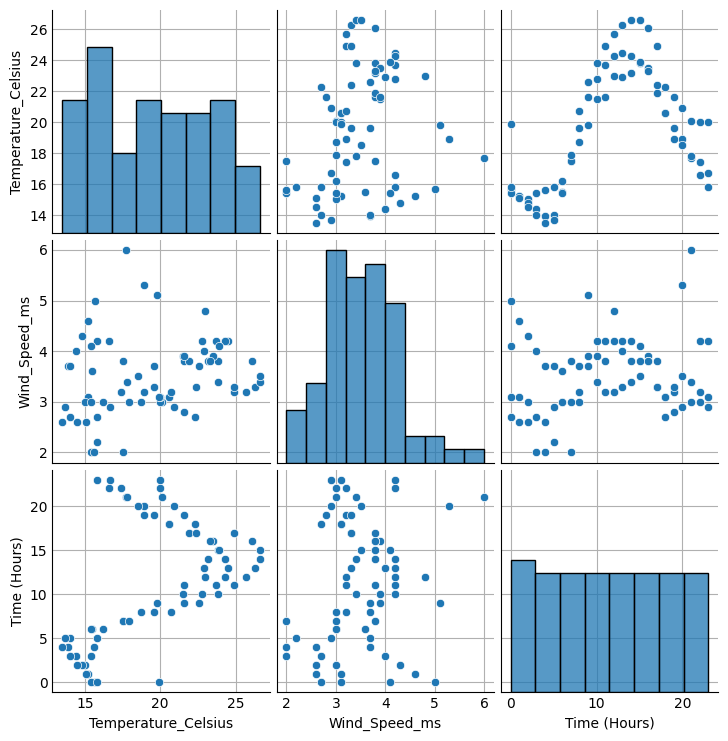

In [55]:
# Create a pair plot of all numeric columns
sns.pairplot(df[['Temperature_Celsius', 'Wind_Speed_ms', 'Time (Hours)']])

# Show plot
plt.show()
